# PoI finding on ASCAD

In [27]:
import h5py
import numpy as np
import psutil
import seaborn as sns
from scipy.stats import beta
from tqdm import tqdm

from src.data.loaders.ascad import ASCADData
from src.data.preprocess.hw import hamming_weights
from src.tools.cache import cache_np
from src.tools.lists import find
from src.tools.plotter import init_plots, store_sns
from src.trace_set.database import Database
from src.trace_set.set_hw import TraceSetHW

init_plots()

In [28]:
RAW_DATA = ASCADData.raw()
RAW_TRACES = RAW_DATA['traces']

Pre-processed in `./ascad.ipynb`

In [29]:
TARGET_BYTE = 0

STATES_PROF = cache_np("full_states_ascad_profile")[:, 0, TARGET_BYTE]
STATES_ATT = cache_np("full_states_ascad_attack")[:, 0, TARGET_BYTE]

HW_PROF = hamming_weights(STATES_PROF)

In [30]:
SUFFIX = "-ascad"
if TARGET_BYTE == 0:
    SUFFIX += "-none"

In [31]:
PROFILING_MASK = np.ones(len(RAW_TRACES) - 1, dtype=bool)
PROFILING_MASK[2::3] = 0
NUM_TRACES = np.sum(PROFILING_MASK)

In [32]:
TRANSPOSE_PATH = './.cache/ASCAD_raw_T.h5'
OVERWRITE = False

In [33]:
def fetch_chunk(raw_traces, profiling_mask, start_sp, end_sp):
    res = np.ones((end_sp - start_sp, profiling_mask.sum()), dtype=np.int8)
    for ix, ix_raw in tqdm(enumerate(np.where(profiling_mask)[0]), total=np.sum(profiling_mask),
                           desc=f"Fetching chunk ({start_sp}:{end_sp})"):
        res[:, ix] = raw_traces[ix_raw, start_sp:end_sp]

    return res

# fetch_chunk(RAW_TRACES, PROFILING_MASK, 0, 1000)[0].shape

In [34]:
def get_chunks(profiling_mask, max_size):
    num_traces = np.sum(profiling_mask)

    chunk_starts = np.arange(0, num_traces, max_size)
    chunks = [(i, min(num_traces, i + max_size)) for i in chunk_starts]

    return chunks

get_chunks(PROFILING_MASK, 66000)

[(0, 66000), (66000, 132000), (132000, 198000), (198000, 200000)]

In [35]:
print(f"Max sample points per chunk ({round((psutil.virtual_memory().total / np.sum(PROFILING_MASK)) * .75)}).")

MAX_CHUNK_SIZE = 100000

Max sample points per chunk (126090).


In [36]:
def create_transpose(file_path, raw_traces, profiling_mask, step=1000):
    num_traces = np.sum(profiling_mask)
    trace_len = raw_traces.shape[1]
    
    with h5py.File(file_path, 'w') as f:
        f.require_dataset("traces", (trace_len, num_traces), dtype=np.int8)

        chunks = get_chunks(profiling_mask, MAX_CHUNK_SIZE)

        for start, end in chunks:
            chunk = fetch_chunk(raw_traces, profiling_mask, start, end)

            for ix, row in tqdm(enumerate(chunk), total=len(chunk), desc="Storing chunk"):
                f["traces"][start + ix] = chunk[ix]

if OVERWRITE:
    create_transpose(TRANSPOSE_PATH, RAW_TRACES, PROFILING_MASK)

In [37]:
def get_corr(transpose_path, labels_01):
    with h5py.File(transpose_path, 'r') as hf:
        sample_points = hf['traces']
        num_sample_points = len(sample_points)

        res_01 = np.zeros(num_sample_points, dtype=np.float64)
        for ix in tqdm(range(num_sample_points)):
            res_01[ix] = np.corrcoef(sample_points[ix], labels_01)[0, 1]

    return np.array(res_01)

print(f"corr-coefficient{SUFFIX}")

CORR = cache_np(f"corr-coefficient{SUFFIX}", get_corr, TRANSPOSE_PATH, HW_PROF)

corr-coefficient-ascad-none


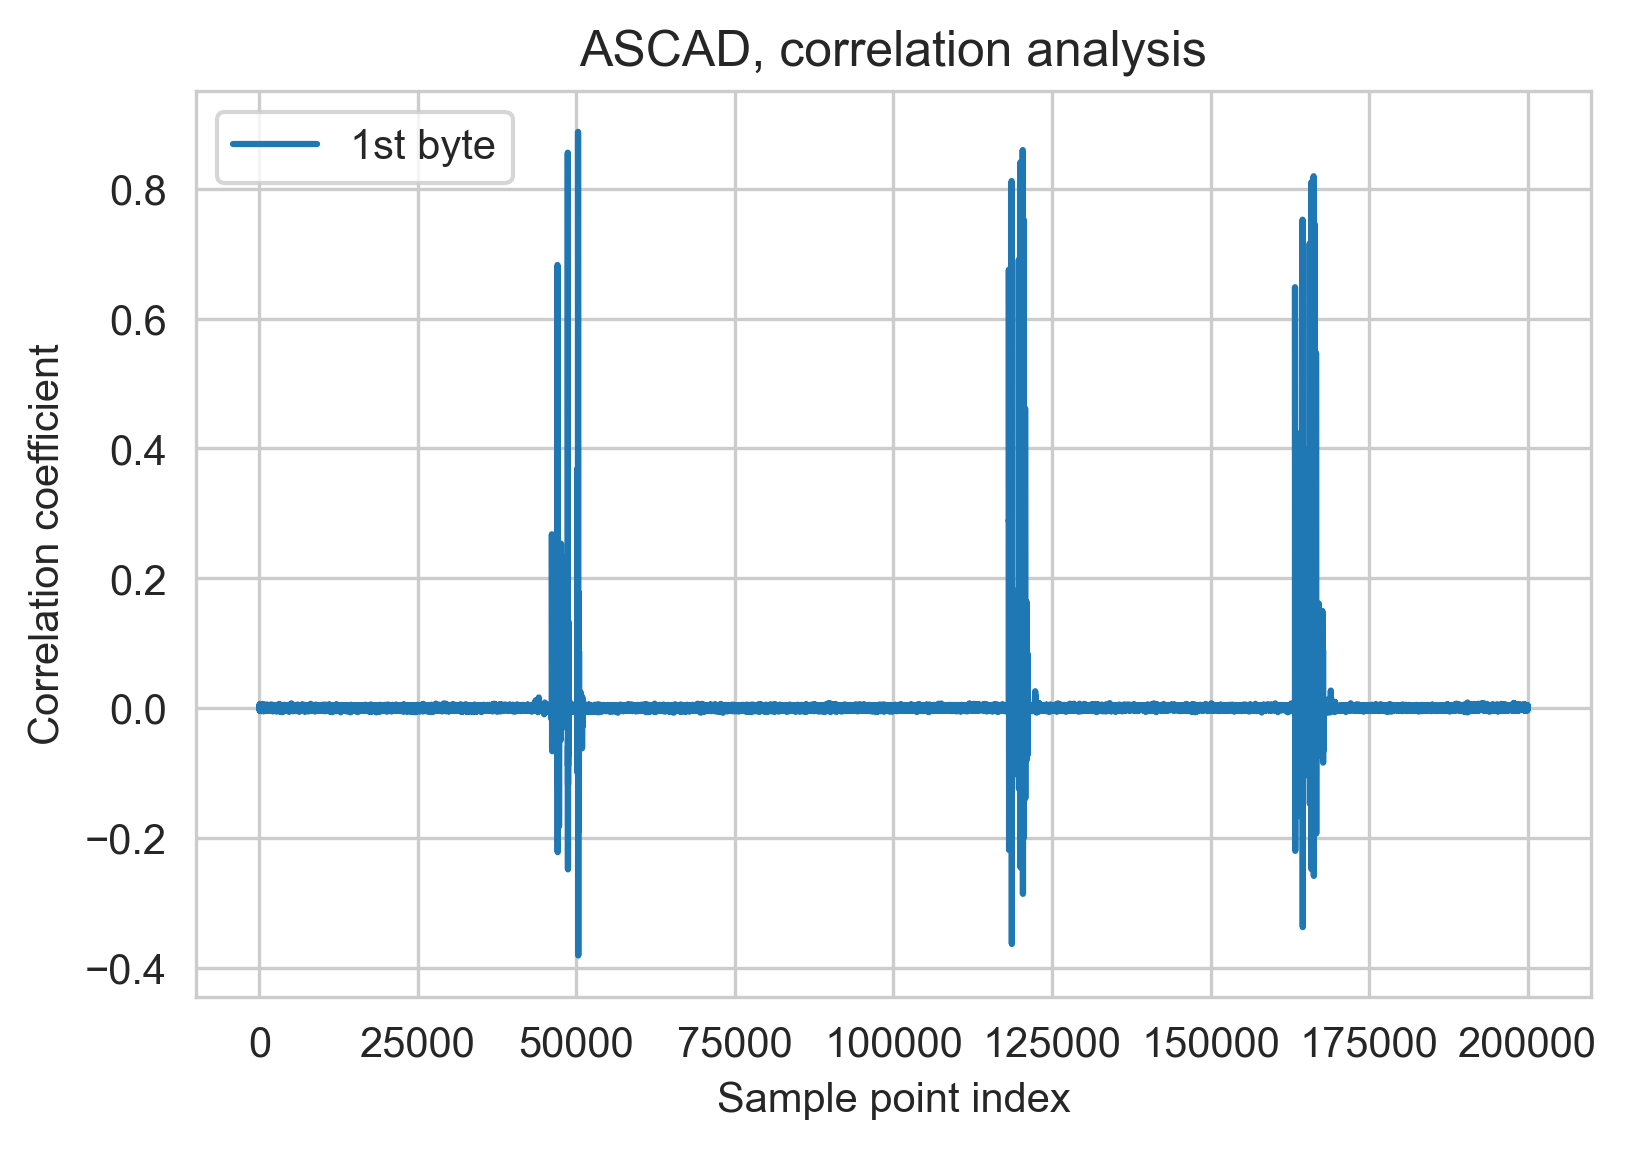

In [38]:
G = sns.lineplot(data={"1st byte": CORR})
G.set(title="ASCAD, correlation analysis", xlabel="Sample point index", ylabel="Correlation coefficient")
store_sns(G, f"correlation{SUFFIX}")

In [39]:
# DIST = beta(NUM_TRACES/2 - 1, NUM_TRACES/2 - 1, loc=-1, scale=2)
# CORR_P = 2 * DIST.cdf(-np.abs(CORR))

In [43]:
DIST = beta(NUM_TRACES/2 - 1, NUM_TRACES/2 - 1, loc=-1, scale=2)
CORR_P = 2 * DIST.cdf(-np.abs(CORR))[:200000]

/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


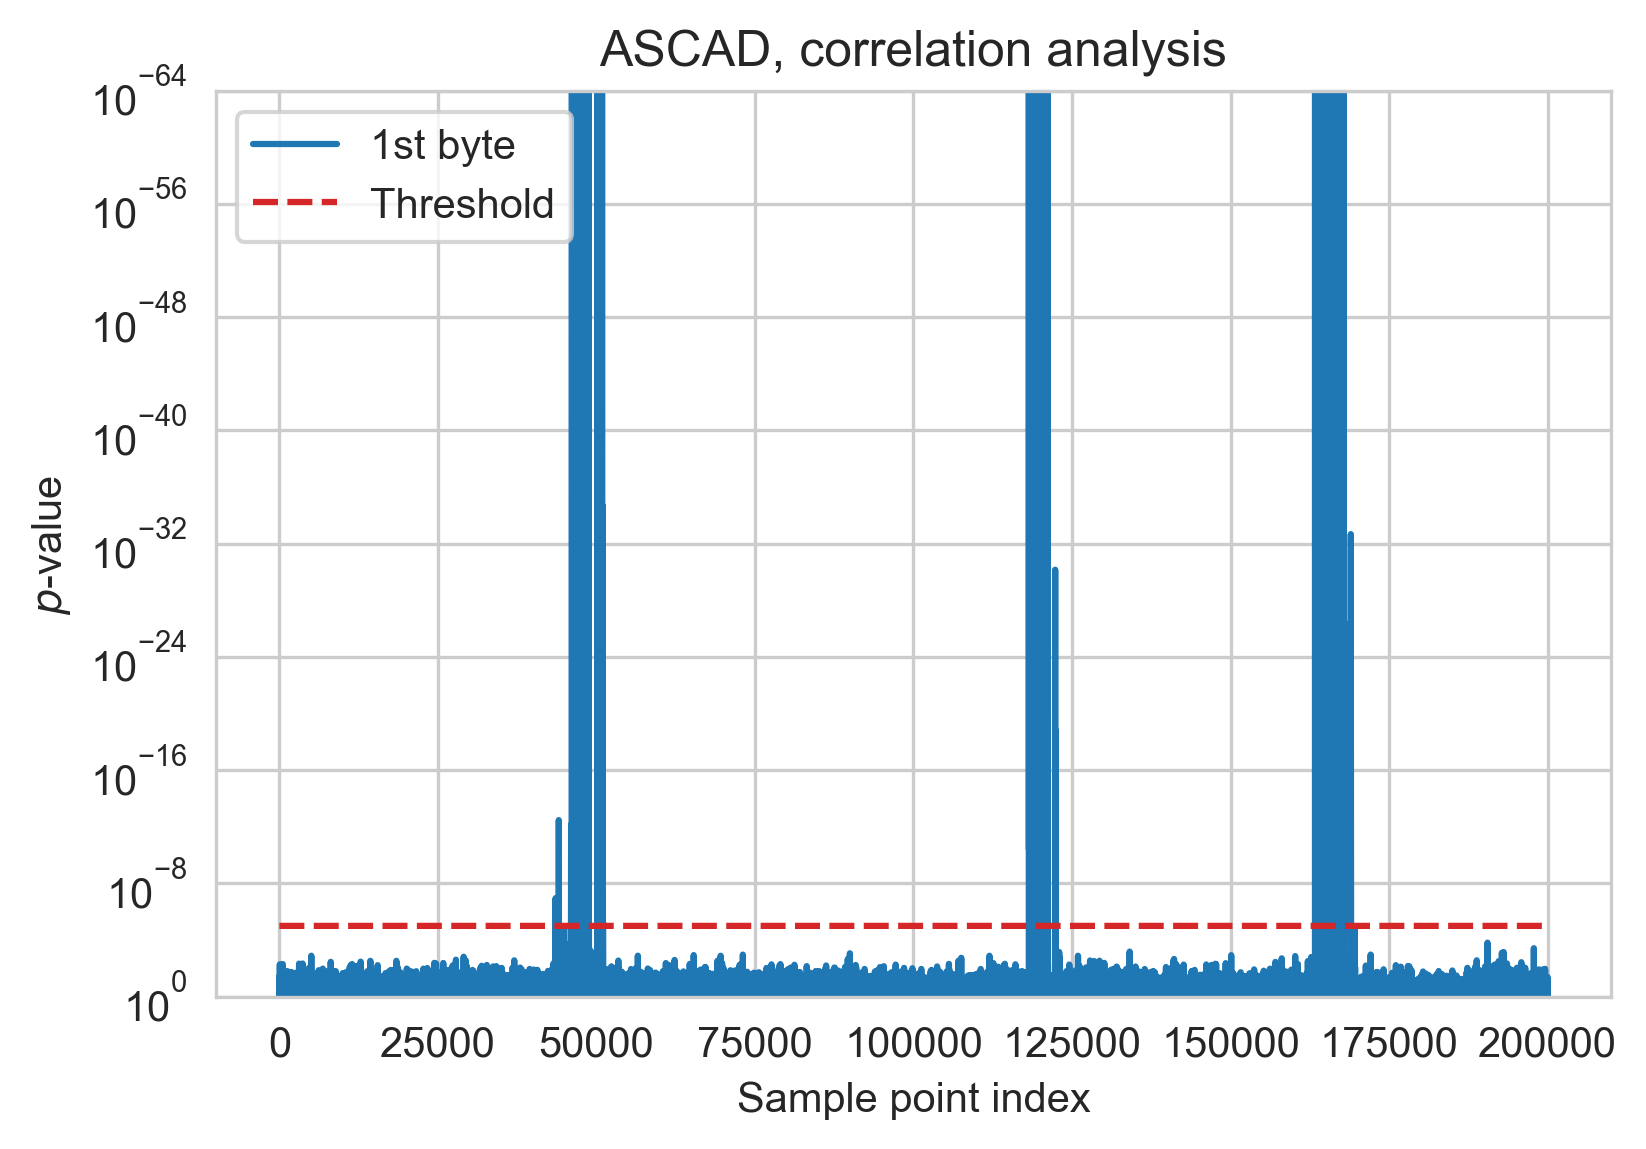

In [44]:
G = sns.lineplot(data={"1st byte": CORR_P, "Threshold": [10 ** -5] * len(CORR_P)}, palette=np.array(sns.color_palette())[[0, 3]])
G.set(title="ASCAD, correlation analysis", xlabel="Sample point index", ylabel="$p$-value", yscale="log", ylim=(10 ** -64, 1))
G.invert_yaxis()
store_sns(G, f"correlation-p{SUFFIX}")

In [ ]:
def get_poi(p_values, window_size = 500, margin = 100, threshold = 10 ** -5):
    res = []
    poi_ixs = np.where(p_values < threshold)[0]
    start = poi_ixs[0]
    prev = start
    for ix in poi_ixs:
        if ix - prev > window_size:
            res.append((start, prev))
            start = ix

        prev = ix

    do_capture = np.array([b - a for a, b in res]) > window_size
    poi = np.array(res)[do_capture]

    return np.array([(max(0, a - margin), min(b + margin, len(p_values))) for a, b in poi])

POI = get_poi(CORR_P, threshold = 10 ** -50)

print("PoI", POI)

SELECTED_POI = POI[0]

In [ ]:
G = sns.lineplot(data={"1st byte": CORR_P})
G.set(title="ASCAD, correlation analysis", xlabel="Sample point index", ylabel="Correlation coefficient", yscale="log", xlim=(193000,193150), ylim=(10 ** -64, 1))
G.invert_yaxis()
# store_sns(G, "correlation-p-ascad-poi-1")

In [ ]:
G = sns.lineplot(data={"1st byte": CORR_P})
G.set(title="ASCAD, correlation analysis", xlabel="Sample point index", ylabel="Correlation coefficient", yscale="log", xlim=(80945,80945 + 1400), ylim=(10 ** -64, 1))
G.invert_yaxis()
# store_sns(G, "correlation-p-ascad-poi-1")

In [ ]:
G = sns.lineplot(data={"1st byte": CORR_P})
G.set(title="ASCAD, correlation analysis", xlabel="Sample point index", ylabel="Correlation coefficient", yscale="log", xlim=SELECTED_POI, ylim=(10 ** -64, 1))
G.invert_yaxis()

In [ ]:
def get_chunk_ixs(num_traces, chunk_size):
    return [(a, min(a + chunk_size, num_traces + 1)) for a in np.arange(0, num_traces, chunk_size)]

In [ ]:
ADAPTED_POI = SELECTED_POI[0] + 1150, SELECTED_POI[0] + 1450

In [ ]:
def create_hw00(raw_traces: np.ndarray, profiling_mask: np.ndarray, states_prof: np.ndarray, states_att: np.ndarray, poi: (int, int)):
    num_traces = len(raw_traces) - 1
    len_poi = poi[1] - poi[0]
    traces = np.zeros((num_traces, len_poi), dtype=raw_traces.dtype)

    for a, b in tqdm(get_chunk_ixs(num_traces, 50000)):
        traces[a:b] = RAW_TRACES[a:b, poi[0]:poi[1]]

    profile = traces[profiling_mask]
    attack = traces[~profiling_mask]

    ts = TraceSetHW(Database.ascad_none)
    ts.create(profile, states_prof, attack, states_att)

# create_hw00(RAW_TRACES, PROFILING_MASK, STATES_PROF, STATES_ATT, ADAPTED_POI)